# Convolutional Variational Autoencoder for CelebA Face Images

## Imports

In [ ]:
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt

#### Import utility functions

In [ ]:
from helper_data import get_dataloaders_EuroSAT
from helper_data import UnNormalize
from helper_train import train_vae_v1
from helper_utils import set_deterministic, set_all_seeds
from helper_plotting import plot_accuracy, plot_training_loss
from helper_plotting import plot_generated_images
from helper_plotting import plot_latent_space_with_labels
from helper_plotting import plot_images_sampled_from_vae

In [ ]:
##########################
### SETTINGS
##########################

# Device
CUDA_DEVICE_NUM = 0
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

# Hyperparameters
RANDOM_SEED = 123
LEARNING_RATE = 0.0005
BATCH_SIZE = 256
NUM_EPOCHS = 50

Device: cuda:0


In [ ]:
set_deterministic
set_all_seeds(RANDOM_SEED)

## Dataset

In [ ]:
##########################
### Dataset
##########################


custom_transforms = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop((128, 128)),
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


train_loader, valid_loader, test_loader = get_dataloaders_EuroSAT(
    batch_size=BATCH_SIZE,
    train_transforms=custom_transforms,
    test_transforms=custom_transforms,
    num_workers=2)

  0%|          | 0/94280567 [00:00<?, ?it/s]

Extracting data/eurosat/EuroSAT.zip to data/eurosat


In [ ]:
# Checking the dataset
print('Training Set:\n')
for images, labels in train_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    #print(labels[:10])
    break

# Checking the dataset
print('\nValidation Set:')
for images, labels in valid_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    #print(labels[:10])
    break

# Checking the dataset
print('\nTesting Set:')
for images, labels in test_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    #print(labels[:10])
    break

"""Targets are 40-dim vectors representing
00 - 5_o_Clock_Shadow
01 - Arched_Eyebrows
02 - Attractive
03 - Bags_Under_Eyes
04 - Bald
05 - Bangs
06 - Big_Lips
07 - Big_Nose
08 - Black_Hair
09 - Blond_Hair
10 - Blurry
11 - Brown_Hair
12 - Bushy_Eyebrows
13 - Chubby
14 - Double_Chin
15 - Eyeglasses
16 - Goatee
17 - Gray_Hair
18 - Heavy_Makeup
19 - High_Cheekbones
20 - Male
21 - Mouth_Slightly_Open
22 - Mustache
23 - Narrow_Eyes
24 - No_Beard
25 - Oval_Face
26 - Pale_Skin
27 - Pointy_Nose
28 - Receding_Hairline
29 - Rosy_Cheeks
30 - Sideburns
31 - Smiling
32 - Straight_Hair
33 - Wavy_Hair
34 - Wearing_Earrings
35 - Wearing_Hat
36 - Wearing_Lipstick
37 - Wearing_Necklace
38 - Wearing_Necktie
39 - Young
"""

Training Set:

Image batch dimensions: torch.Size([256, 3, 128, 128])
Image label dimensions: torch.Size([256])

Validation Set:
Image batch dimensions: torch.Size([256, 3, 128, 128])
Image label dimensions: torch.Size([256])

Testing Set:
Image batch dimensions: torch.Size([256, 3, 128, 128])
Image label dimensions: torch.Size([256])


'Targets are 40-dim vectors representing\n00 - 5_o_Clock_Shadow\n01 - Arched_Eyebrows\n02 - Attractive \n03 - Bags_Under_Eyes\n04 - Bald\n05 - Bangs\n06 - Big_Lips\n07 - Big_Nose\n08 - Black_Hair\n09 - Blond_Hair\n10 - Blurry \n11 - Brown_Hair \n12 - Bushy_Eyebrows \n13 - Chubby \n14 - Double_Chin \n15 - Eyeglasses \n16 - Goatee \n17 - Gray_Hair \n18 - Heavy_Makeup \n19 - High_Cheekbones \n20 - Male \n21 - Mouth_Slightly_Open \n22 - Mustache \n23 - Narrow_Eyes \n24 - No_Beard \n25 - Oval_Face \n26 - Pale_Skin \n27 - Pointy_Nose \n28 - Receding_Hairline \n29 - Rosy_Cheeks \n30 - Sideburns \n31 - Smiling \n32 - Straight_Hair \n33 - Wavy_Hair \n34 - Wearing_Earrings \n35 - Wearing_Hat \n36 - Wearing_Lipstick \n37 - Wearing_Necklace \n38 - Wearing_Necktie \n39 - Young         \n'

## Model

In [ ]:
##########################
### MODEL
##########################


class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :128, :128]


class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
                nn.Conv2d(3, 32, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Conv2d(32, 64, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Conv2d(64, 64, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Conv2d(64, 64, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Flatten(),
        )

        self.z_mean = torch.nn.Linear(4096, 200)
        self.z_log_var = torch.nn.Linear(4096, 200)

        self.decoder = nn.Sequential(
                torch.nn.Linear(200, 4096),
                Reshape(-1, 64, 8, 8),
                #
                nn.ConvTranspose2d(64, 64, stride=2, kernel_size=3),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.ConvTranspose2d(64, 64, stride=2, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.ConvTranspose2d(64, 32, stride=2, kernel_size=3, padding=1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.ConvTranspose2d(32, 3, stride=2, kernel_size=3, padding=1),
                #
                Trim(),  # 3x129x129 -> 3x128x128
                nn.Sigmoid()
                )


    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded


    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.get_device())
        z = z_mu + eps * torch.exp(z_log_var/2.)
        return z

    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded

In [ ]:
set_all_seeds(RANDOM_SEED)

model = VAE()
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Training

In [ ]:
log_dict = train_vae_v1(num_epochs=NUM_EPOCHS, model=model,
                        optimizer=optimizer, device=DEVICE,
                        train_loader=train_loader,
                        skip_epoch_stats=True,
                        logging_interval=50,
                        save_model='vae_EuroSAT_02.pt')

Epoch: 001/050 | Batch 0000/0106 | Loss: 11092.2979
Epoch: 001/050 | Batch 0050/0106 | Loss: 4837.8521
Epoch: 001/050 | Batch 0100/0106 | Loss: 2058.9822
Time elapsed: 0.32 min
Epoch: 002/050 | Batch 0000/0106 | Loss: 1881.7424
Epoch: 002/050 | Batch 0050/0106 | Loss: 1077.2117
Epoch: 002/050 | Batch 0100/0106 | Loss: 708.5555
Time elapsed: 0.63 min
Epoch: 003/050 | Batch 0000/0106 | Loss: 650.2560
Epoch: 003/050 | Batch 0050/0106 | Loss: 515.9464
Epoch: 003/050 | Batch 0100/0106 | Loss: 408.3944
Time elapsed: 0.94 min
Epoch: 004/050 | Batch 0000/0106 | Loss: 384.1371
Epoch: 004/050 | Batch 0050/0106 | Loss: 333.7275
Epoch: 004/050 | Batch 0100/0106 | Loss: 318.8652
Time elapsed: 1.25 min
Epoch: 005/050 | Batch 0000/0106 | Loss: 286.6203
Epoch: 005/050 | Batch 0050/0106 | Loss: 287.0882
Epoch: 005/050 | Batch 0100/0106 | Loss: 238.0596
Time elapsed: 1.57 min
Epoch: 006/050 | Batch 0000/0106 | Loss: 250.9445
Epoch: 006/050 | Batch 0050/0106 | Loss: 241.9321
Epoch: 006/050 | Batch 0100/0

## Evaluation

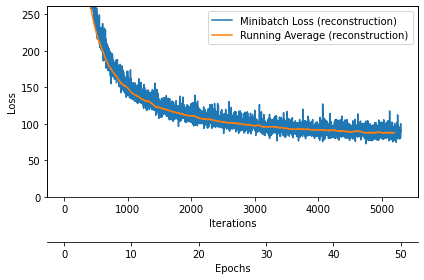

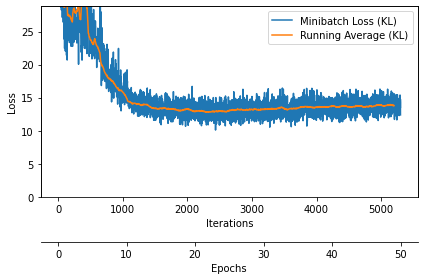

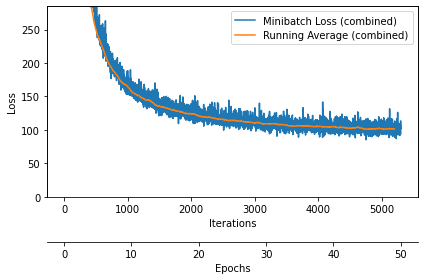

In [ ]:
plot_training_loss(log_dict['train_reconstruction_loss_per_batch'], NUM_EPOCHS, custom_label=" (reconstruction)")
plot_training_loss(log_dict['train_kl_loss_per_batch'], NUM_EPOCHS, custom_label=" (KL)")
plot_training_loss(log_dict['train_combined_loss_per_batch'], NUM_EPOCHS, custom_label=" (combined)")
plt.show()

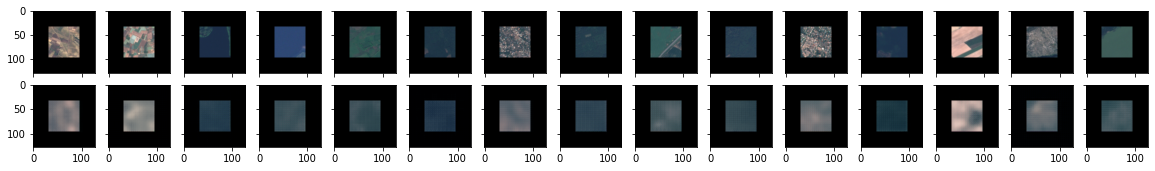

In [ ]:
#unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
plot_generated_images(data_loader=train_loader,
                      model=model,
                      #unnormalizer=unnormalizer,
                      device=DEVICE,
                      modeltype='VAE')

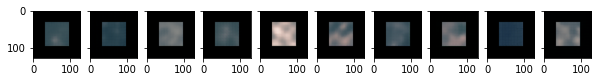

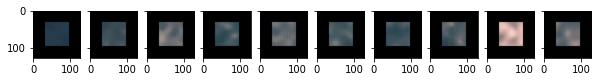

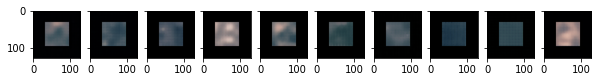

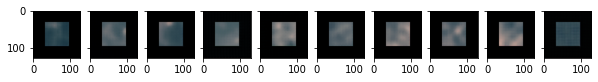

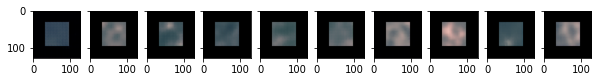

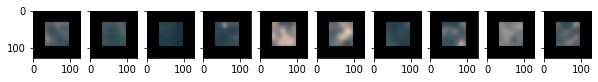

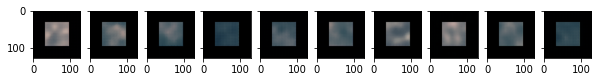

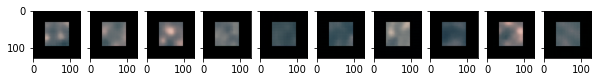

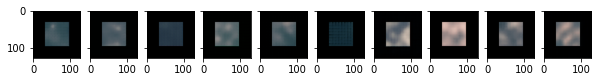

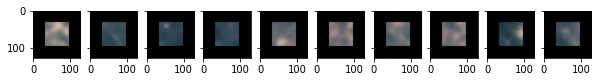

In [ ]:
for i in range(10):
    plot_images_sampled_from_vae(model=model, device=DEVICE, latent_size=200)
    plt.show()